In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install bpemb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pwd

/content/drive/MyDrive/Colab Notebooks/nlptasks/notebooks/hroi-temp


In [3]:
%cd drive/MyDrive/Colab\ Notebooks/nlptasks/notebooks/hroi-temp

/content/drive/MyDrive/Colab Notebooks/nlptasks


In [ ]:
#!git clone https://github.com/hrobjarturh/nlptasks.git
#!git pull

remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/hrobjarturh/nlptasks
   e6b7406..461a058  main       -> origin/main
Updating e6b7406..461a058
Fast-forward
 notebooks/hroi-temp/sub12.ipynb | 444 ++++++++++++++++++++++++++++++++++++++++
 1 file changed, 444 insertions(+)
 create mode 100644 notebooks/hroi-temp/sub12.ipynb


In [6]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
from bpemb import BPEmb
import gensim.downloader
from bpemb import BPEmb


In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

In [9]:
enforce_reproducibility()

In [10]:
bpemb_en = BPEmb(lang='en', dim=100, vs=65320)
# Extract the embeddings and add a randomly initialized embedding for our extra [PAD] token
pretrained_embeddings = np.concatenate([bpemb_en.emb.vectors, np.zeros(shape=(1,100))], axis=0)

BPEmb fallback: en from vocab size 65320 to 200000


In [93]:
np.concatenate([[1,2], np.zeros(shape=(1,100))], axis=0)

ValueError: ignored

In [12]:
from torch import nn

# Define a default lstm_dim
lstm_dim = 100

In [44]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

In [16]:
from torch.optim import Adam

In [17]:
# Define some hyperparameters
batch_size = 32
lr = 3e-4
n_epochs = 2

In [18]:
def accuracy(logits, labels):
  logits = np.asarray(logits).reshape(-1, len(logits[0]))
  labels = np.asarray(labels).reshape(-1)
  return np.sum(np.argmax(logits, axis=-1) == labels).astype(np.float32) / float(labels.shape[0])

In [19]:
from tqdm import tqdm_notebook as tqdm

In [20]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      _, logits = model(input_ids, seq_lens, labels=labels)
      labels_all.extend(list(labels.detach().cpu().numpy()))
      logits_all.extend(list(logits.detach().cpu().numpy()))
    acc = accuracy(logits_all, labels_all)

    return acc,labels_all,logits_all

In [21]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    patience: int = 10
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0
  pcounter = 0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    acc,_,_ = evaluate(model, valid_dl)
    print(f'Validation accuracy: {acc}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if acc > best_acc:
      torch.save(model.state_dict(), 'best_model')
      best_acc = acc
      pcounter = 0
    else:
      pcounter += 1
      if pcounter == patience:
        break
        #gc.collect()

  model.load_state_dict(torch.load('best_model'))
  return model, losses

In [22]:
# use eval to change string list to list get the length of each row
def create_batch(df):
  combined = [eval(que) + eval(doc) for que, doc in zip(df["question_text_tokenized"],df["document_plaintext_tokenized"])]
  flat_combined = np.array([item for sublist in combined for item in sublist])

  dictionary = Counter(flat_combined) # create dict
  dictionary_sorted = sorted(dictionary, key=dictionary.get, reverse=True) # sorted dict

  text_id = [[dictionary_sorted.index(word) for word in text] for text in combined] # indexes of doc location

  text_lens = [len(i) for i in combined] # length of all doc lists
  max_length = max(text_lens) # max length of doc
  dictionary_sorted.append('[PAD]') # add padding token to dictionary
  pad_index = dictionary_sorted.index('[PAD]') # get pad index

  padded_text_id = [(i + [pad_index] * (max_length - len(i))) for i in text_id] # ad padding to all tex id

  return padded_text_id, text_lens, df.labels.values
  

In [23]:
#collate_fn=collate_batch_bilstm
def collate_batch_bilstm_t(data):
    #return torch.tensor(train_dataset[0]), torch.tensor(train_dataset[1]), torch.tensor(train_dataset[2])
    return torch.tensor([f for f in train_dataset[0]]), torch.tensor([f for f in train_dataset[1]]), torch.tensor([f for f in train_dataset[2]])

def collate_batch_bilstm_v(data):
    #return torch.tensor(train_dataset[0]), torch.tensor(train_dataset[1]), torch.tensor(train_dataset[2])
    return torch.tensor([f for f in valid_dataset[0]]), torch.tensor([f for f in valid_dataset[1]]), torch.tensor([f for f in valid_dataset[2]])

def collate_batch_bilstm_test(data):
    #return torch.tensor(train_dataset[0]), torch.tensor(train_dataset[1]), torch.tensor(train_dataset[2])
    return torch.tensor([f for f in test_dataset[0]]), torch.tensor([f for f in test_dataset[1]]), torch.tensor([f for f in test_dataset[2]])


In [24]:
# import training data
dft_eng = pd.read_csv('../../data/dft_eng.csv')

# import validation data
dfv_eng = pd.read_csv('../../data/dfv_eng.csv')

In [25]:
from sklearn.utils import shuffle
dft_eng = shuffle(dft_eng)
dft_eng.reset_index(inplace=True, drop=True)
dfv_eng = shuffle(dfv_eng)
dfv_eng.reset_index(inplace=True, drop=True)

In [107]:
train_dataset = create_batch(dft_eng.iloc[:3]) # 500 for training
valid_dataset = create_batch(dfv_eng.iloc[:3]) # 500 for validation
test_dataset = create_batch(dft_eng.iloc[3:6]) # rest of training for testing

In [108]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=collate_batch_bilstm_t, num_workers=8)
valid_dl = DataLoader(valid_dataset, batch_size=32,collate_fn=collate_batch_bilstm_v, num_workers=8)
test_dl = DataLoader(test_dataset, batch_size=32, collate_fn=collate_batch_bilstm_test, num_workers=8)

In [152]:
# Define the model
class BiLSTMNetwork(nn.Module):
    """
    Basic BiLSTM network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTMNetwork, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                1,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'cls': nn.Linear(2*lstm_dim, n_classes)
        })
        self.n_classes = n_classes
        self.dropout = nn.Dropout(p=dropout_prob)

        # add ling features
        self.meta_input = meta_input = torch.empty(3,2)
        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['cls'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        #cat = (torch.cat((self.meta_input, lstm_out)),)
        #print(cat.shape)
        #print(lstm_out.shape)
        #print(lstm_out)

        # Max pool along the last dimension
        ff_in = self.dropout(torch.max(lstm_out, 1)[0])
        # Some magic to get the last output of the BiLSTM for classification (b x 2*lstm_dim)
        #ff_in = lstm_out.gather(1, input_lens.view(-1,1,1).expand(lstm_out.size(0), 1, lstm_out.size(2)) - 1).squeeze()

        #ff_in = torch.cat((ff_in, self.meta_input), 1)

        # Get logits (b x n_classes)
        logits = self.model['cls'](ff_in).view(-1, self.n_classes)
        outputs = (logits,)
        if labels is not None:
            # Xentropy loss
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            outputs = (loss,) + outputs

        return outputs


# Create the model
model = BiLSTMNetwork(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=0.1, 
    n_classes=2
  ).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [153]:
# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)

# Train
model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [111]:
Input = torch.tensor([[2],[2],[139],[200]])
lstm = torch.tensor([[[],[],[]],[[[],[],[]]])


In [147]:
lstm_out = torch.empty(3, 200)
meta_input = torch.empty(3,2)

In [148]:
meta_input

tensor([[2.6988e-30, 0.0000e+00],
        [2.5631e-01, 0.0000e+00],
        [       nan, 0.0000e+00]])

In [151]:
torch.cat((lstm_out, meta_input), 1)

tensor([[6.9438e-21, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2173e+16, 4.5768e-41,
         6.0750e-38, 0.0000e+00, 1.4013e-45, 0.0000e+00,        nan,        nan,
                nan,        nan, 0.0000e+00, 0.0000e+00, 1.4013e-45, 2.5639e-09,
         0.0000e+00, 0.0000e+00, 1.2612e-44, 0.0000e+00, 1.2173e+16, 4.5768e-41,
         6.0759e-38, 0.0000e+00,        nan,        nan, 0.0000e+00, 0.0000e+00,
                nan,        nan, 0.0000e+00, 0.0000e+00, 1.4013e-45, 9.8439e-12,
         1.0089e-43, 0.0000e+00, 1.5414e-44, 0.0000e+00, 1.2173e+16, 4.5768e-41,
         6.0770e-38, 0.0000e+00, 7.0065e-45, 0.0000e+00, 1.4013e-44, 0.0000e+00,
                nan,        nan, 0.0000e+00, 0.0000e+00, 1.4013e-45, 1.3563e-19,
         2.0179e-43, 0.0000e+00, 1.5414e-44, 0.0000e+00, 1.2173e+16, 4.5768e-41,
         6.0773e-38, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6434e-44, 0.0000e+00,
                nan,        nan, 0.0000e+00, 0.0000e+00, 1.4013e-45, 0.0000e+00,
         3.0268e-43, 0.0000e

In [145]:
lstm_out

tensor([[ 6.9479e-21,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2121e+16,
          4.5768e-41,  6.0750e-38,  0.0000e+00,  1.4013e-45,  0.0000e+00,
                 nan,         nan,         nan,         nan,  0.0000e+00,
          0.0000e+00,  1.4013e-45,  1.5046e-36,  0.0000e+00,  0.0000e+00,
          1.2612e-44,  0.0000e+00,  1.2121e+16,  4.5768e-41,  6.0759e-38,
          0.0000e+00,         nan,         nan,  0.0000e+00,  0.0000e+00,
                 nan,         nan,  0.0000e+00,  0.0000e+00,  1.4013e-45,
          4.5768e-41,  1.0089e-43,  0.0000e+00,  1.5414e-44,  0.0000e+00,
          1.2121e+16,  4.5768e-41,  6.0770e-38,  0.0000e+00,  7.0065e-45,
          0.0000e+00,  1.4013e-44,  0.0000e+00,         nan,         nan,
          0.0000e+00,  0.0000e+00,  1.4013e-45,  4.5768e-41,  2.0179e-43,
          0.0000e+00,  1.5414e-44,  0.0000e+00,  1.2121e+16,  4.5768e-41,
          6.0773e-38,  0.0000e+00, -9.8528e+26,  3.6318e+28,  3.6434e-44,
          0.0000e+00,         nan,    

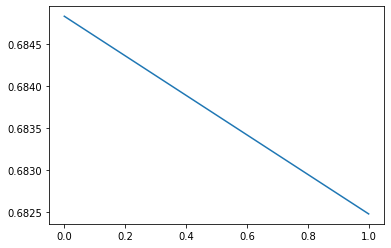

In [29]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [30]:
val_acc,_,_ = evaluate(model, valid_dl)
test_acc,labs,logs = evaluate(model, test_dl)
print(f"Valiation accuracy: {val_acc}")
print(f"Test accuracy: {test_acc}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Valiation accuracy: 0.48
Test accuracy: 0.5


In [ ]:
len(test_dataset)

3

In [ ]:
dfv_eng = pd.read_csv('data/dfv_eng.csv')

In [ ]:
dfv_eng = shuffle(dfv_eng)
dfv_eng.reset_index(inplace=True, drop=True)

In [ ]:
test_dataset = create_batch(dfv_eng)
test_dl = DataLoader(test_dataset, batch_size=len(test_dataset), collate_fn=collate_batch_bilstm_test, num_workers=8)

In [ ]:
len(test_dataset[0])

990

In [ ]:
len(dfv_eng)

7389